In [1]:
import pandas as pd

import os



In [2]:
HOUSING_PATH = 'input/housing.csv'
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = HOUSING_PATH
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> Now we'll try to find out what categories exist and how mant districts belong to each category

In [9]:
housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


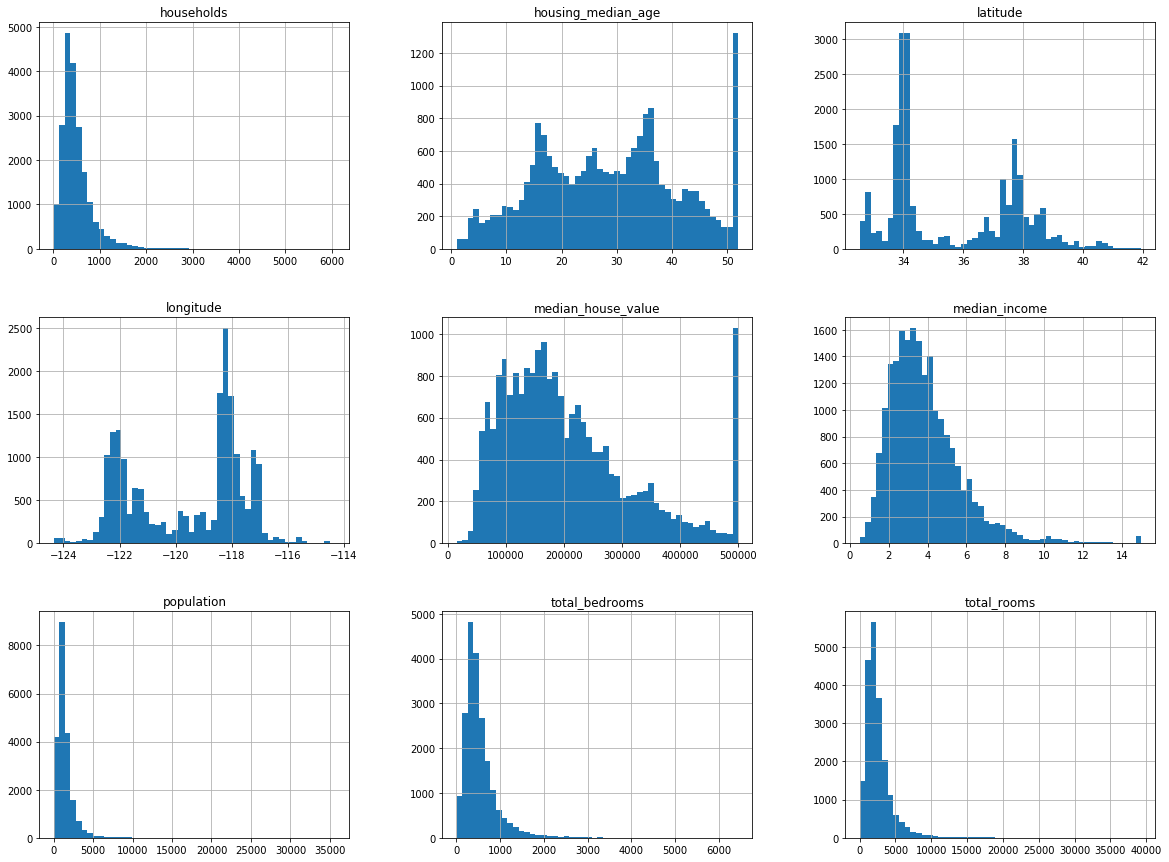

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

**Create Test set**

In [12]:
import numpy as np
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set),"train +", len(test_set),"test")

16512 train + 4128 test


In [14]:
import hashlib
def test_set_check(identifier, test_ratio,hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio,hash))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index()
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [16]:
housing_with_id["id"] = housing["longitude"] *1000 +housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"id")

In [17]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [18]:
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

**Remove the income_cat attribute so the data is back to its original state**

In [21]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis = 1, inplace=True)

**Copy of training set**

In [22]:
housing = strat_train_set.copy()

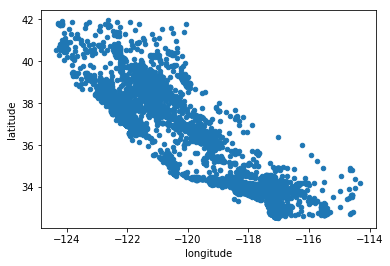

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

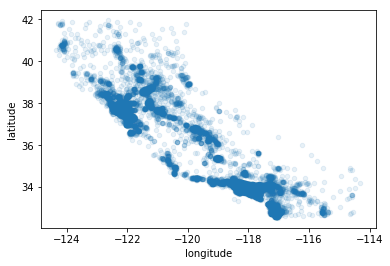

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

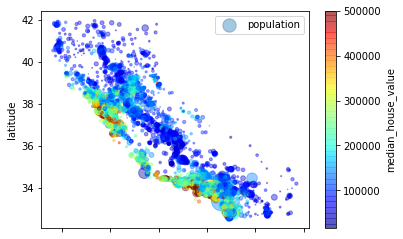

In [25]:
housing.plot(kind="scatter", x="longitude",y="latitude", alpha=0.4,s=housing["population"]/100 , label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
#plt.show()

**Looking for correlation:**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020ED98F9240>,
      dtype=object)

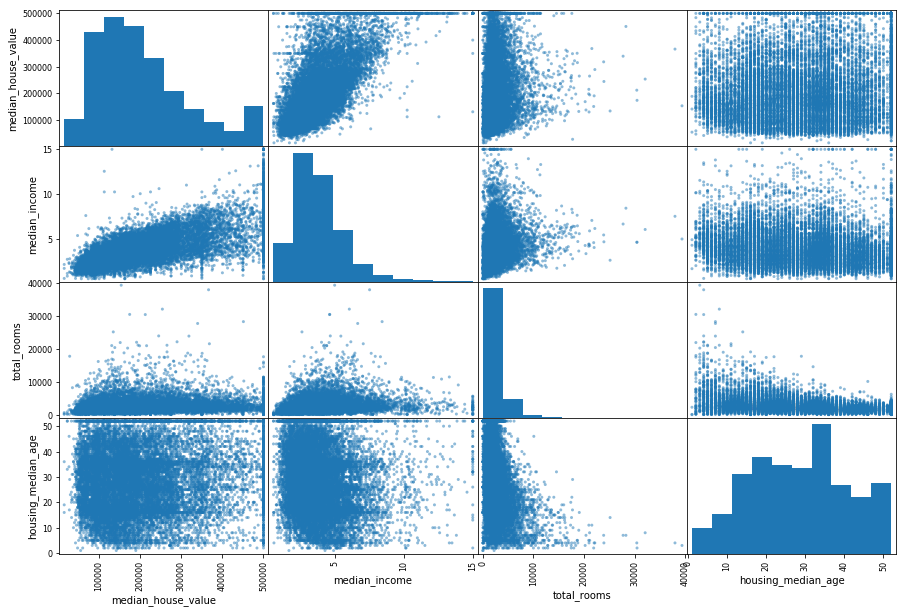

In [26]:
#from pandas.tools.plotting import scatter_matrix
#import pandas.plotting.scatter_matrix as psm
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

#scatter_matrix(housing[attributes], fig_size=(12,8))
#psm(housing[attributes], fig_size=(12,8))
scatter_matrix(housing[attributes], figsize=(15,10))

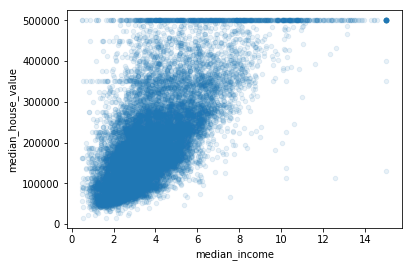

In [27]:
housing.plot(kind="scatter", x="median_income",y="median_house_value", alpha=0.1)

**Experimenting with attribute Combinations**

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedroom_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

**look at the correlation matrix again**

In [29]:
corr_matrix = housing.corr()

In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

Prepare data for machine learning algorithms

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [32]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

**SciKit-Learn provide a handy class to take care of missing values**

In [15]:
import sklearn

#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

In [16]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [17]:
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [18]:
housing_num.median().values

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

**Now use this "trained" imputer to transform the training set by replacing missing values by the learned medians:**

In [19]:
x= imputer.transform(housing_num)

**The result is a plain numpy array containing the transformed features. If you want to put it back in to a pandas Dataframe, Use Below:**

In [20]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns)

In [21]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0


**Handling Text and categorical Attributes**

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

**Here converting text label to numbers**

In [23]:
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

In [24]:
housing_cat_encoded

array([3, 3, 3, ..., 1, 1, 1])

In [26]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>